Code Parallelization with mpi4py
================

In our previous lesson on the topic of parallelization, we used the idea of _code vectorization_ to speed up computation. By thinking about how we could use better data structures (numpy arrays, instead of Python lists), as well as how to do operations on many elements of a vector concurrently, we were able to speed up our simulation of a random walk. In this lesson, we build on those ideas and introduce another way to gain speedups.

To do so, we take ideas from high-performance computing (HPC) to take advantage of the fact that modern computers (and supercomputers/computing clusters) often have more than 1 CPU. As such, it makes sense that, if we have a problem where the compute work can be split apart, that we take advantage of those additional CPUs. To do so, we have to develop and understanding of how our computer's hardware works, as well as what kinds of tools we need.

General Ideas of Multi-Purpose Parallelization
----------------------------

We can think of multi-purpose parallelization as the more general problem of how to do parallelization. For example, some problems which fall under this category could include:

* Monte Carlo simulation (such as the random walk simulator from the previous lesson)
* Solving systems of differential equations
* Performing analytics on "big data"
* Machine learning algorithms

Each problem above has its own challenges to being parallelized. Before we discuss one particular set of problems for which parallelization is straightforward, we need to learn a little bit about some jargon associated with compute hardware.

**Cores, Nodes, Threads, Processes, Oh My!**

These days -- particularly in the realm of building supercomputers -- a big question is "How much work can you do, and how fast can you do it?". To answer such questions, people may discuss:

* How many **CPU**s are on the machine: The CPU is often called the "brain" of the computer, as it is the piece of hardware responsible for controlling the execution of instructions and code. Most modern computers have several CPUs.
* The number of **cores**: Each CPU on your machine may have several cores. Each core is capable of receiving instructions from the CPU and performing calculations. (You may have heard the phrase "dual-core" or "quad-core" when looking at the specs for your CPU.)
* How many **processes** may be executed by the machine: A process is a set of instructions with memory specifically reserved for it. Your machine runs many processes while you are surfing the web, writing a document, etc.
* How many **threads** each core can support: A thread is also a set of instructions, but threads do not necessarily have their own specific memory allocation.

Different CPU architectures support different numbers of threads. Your operating system typically controls the number of processes you as a user may spawn.

In the supercomputing world, the idea of a **node** is also important. A node consists of CPUs, memory, and connections to other nodes. (For example, the [Tianhe-2](https://en.wikipedia.org/wiki/Tianhe-2) supercomputer has 16000 nodes, and each has its own set of CPUs and co-processors. More close to home, UNM's Center for Advanced Research Computing [will be installing](http://www.carc.unm.edu/news/2017/03/lanl-donation-adding-to-unm-supercomputing-power.html) a new machine which has 500 nodes.) If we are doing development on our local laptop/desktop, the idea of a node is basically irrelevant.

(For more information and perspective on parallelized computation, see [this page](https://computing.llnl.gov/tutorials/parallel_comp/) from Lawrence Livermore National Laboratory.)

**Communicating Between Processes - the MPI Standard**

When executing parallelized code, it is often the case that we send some part of the problem to one process, another part to a different process, and we expect that those two processes will communicate with one another as the computation proceeds. [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface) is a standard which specifies a protocol for how that communication should occur. Although understanding the exact specification is 
beyond the scope of this lesson, we do need to understand a few things about it:

* Communication between processes takes place using a ``Communicator``. The communicator "hooks up" processes to talk to one another.

* To keep track of which process is doing what work, MPI assigns each process a value for its ``rank``. The rank is a unique identifier for that process.

* There are communicators which enable _global_ communication, allowing processes to talk to all other processes. Such communication is useful when, for example, a single process is suppose to be "orchestrating" the computation, and sending out work to other processes.

* ``mpi4py`` is a particular _implementation_ of the MPI standard

Evaluating Multiple Function Inputs - the "Embarrasing/Pleasingly Parallel" Case
-------------------------

Because general-purpose parallelization is a broad topic, this lesson is going to focus on a particular sub-topic which often comes up in physics simulations, known as "embarassingly" or "pleasingly" parallel problems. These problems have the property that the work which needs to be done by any given process can be computed _completely independently of all other processes_. ([Appararently](https://en.wikipedia.org/wiki/Embarrassingly_parallel), the phrase "embarassingly" has the same sentiment as in the phrase "an embarassment of riches".)

Such problems generally take the form of evaluating some function $f(\mathbf{x})$ on many inputs $\mathbf{x}$, where $f(\mathbf{x})$ is independent of the value of some other input $\mathbf{x}'$. These kinds of problems naturally arise in, say, creating some kind of phase diagram - we are interested in the behavior of some order parameter or other quantity of interest as we sweep the parameters of our simulation.

In this lesson, we'll figure out how to parallelize the computation of the mean displacement of a random walker over various values of $p$, the probability the walker moves to the left or right.

Saying Hello to Your Computer Hardware
===================

As mentioned above, modern laptops typically have more than 1 CPU. Find out how many CPUs your laptop has:

* Linux/MacOS: This information should be available through your "About this Mac/About this Computer" prompt.
* Windows: This information is probably available by looking up the specs for your device.

To give an example, information about my Linux laptop is below.

In [3]:
from IPython.display import Image

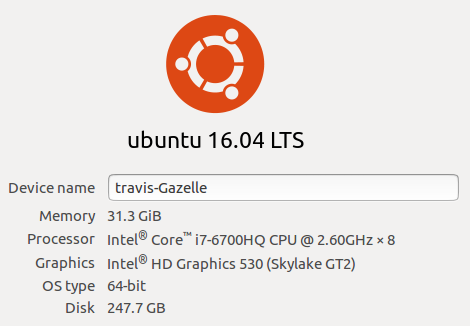

In [4]:
Image('system_info.png')

My laptop has one Intel i7 CPU; according to Intel's documentation, each CPU has 4 cores and 8 threads. Thus, I could probably spwan up to 8 processes without any problems.

Examining MPI - "Hello World"
================

Let's write a simple code to show how to write and execute MPI code. Create a new text file, ``mpi_hello.py``, and put the following code in it.

```python
from mpi4py import MPI

comm = MPI.COMM_WORLD

rank = comm.Get_rank()

print('Hello from {0}!'.format(rank))
```

Although the code above is entirely valid Python, and Jupyter will happily execute it, there are some subtleties in how to actually exeucte parallelized code from within a Jupyter notebook. (Briefly, even if the code looks like its executing, at the hardware level, we might not actually be taking advantage of all the processes!)

Once you've saved ``mpi_hello.py``, you can execute it from the command line as follows:

```
mpiexec -n [number of processes] python mpi_hello.py
```

You should get an output that looks similar to

```
Hello from 4!
Hello from 9!
Hello from 3!
Hello from 7!
Hello from 8!
Hello from 2!
Hello from 1!
Hello from 6!
Hello from 0!
Hello from 5!
```

(I called ``mpiexec`` with 10 processes.)

**What happened?**

What did the command line do? The function call ``mpiexec -n [number of processes]`` tells the MPI software on our machine to spawn new processes. The end of the function call ``python mpi_hello.py`` tells MPI to send to each process the instruction "call ``python mpi_hello.py``".

Once each process makes its Python call, then a new Python interpreter is spun up for each process, and the code inside ``mpi_hello.py`` is executed. Let's take a look at that.

The first line
```python
from mpi4py import MPI
```

simply tells Python to go get the MPI module from the ``mpi4py`` package. This module exposes the functions we need in order to be able to communicate between processes.

The second line
```python
comm = MPI.COMM_WORLD
```

instantiates a communicator which allows communication with all the processes we created when we invoked ``mpiexec``.

The third line
```python
rank = comm.Get_rank()
```

Uses the ``Get_rank()`` method of the communicator to get the rank assigned MPI assigned to the process. (Recall the rank is a unique identifer within the communicator.)

Finally, we printed out the rank using 
```python
print('Hello from {0}!'.format(rank))
```
Now that we've done a hello world, let's try something a bit more complicated. We have an eye towards parallelizing our random walk simulator over values of $p$. Let's figure out how to do some simple logic on each process.

Examining MPI - "Hello Randomness"
===============

Using randomness in a parallelized setting can be tricky. Recall that ``numpy`` provides access to several random number generators, as well as a method ``numpy.random.seed()`` to fix the seed of the random number generator. Fixing the seed allows us to have _reproducible randomness_, meaning that, every time we call our code with a fixed value of the seed, we get back the same (random) results.


One way we could parallelize our code over $p$ goes as follows:

* Spawn many processes.
* Within each process, fix the random number seed.
* Call ``numpy.random.uniform(0, 1)`` to generate a single random value for $p$. 

Randomness by Setting a Fixed Seed Across All Processes
---------------

Create a new file, ``mpi_hello_random-1.py``, and put the following code in it.

```python
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD

rank = comm.Get_rank()

np.random.seed(0)

p = np.random.uniform(0, 1)

print('Hello from {0}! I have value {1}'.format(rank, p))
```

From the command line, execute this file using ``mpiexec``:

```
mpiexec -n [number of processes] python mpi_hello_random-1.py
```

You should obtain an output which is similar to this

```
Hello from 2. My random value is 0.5488135039273248
Hello from 0. My random value is 0.5488135039273248
Hello from 1. My random value is 0.5488135039273248
```

though the exact random value may be different.

At first glance, we might think "_What's going on here_?". After all, we don't want each process to use the _same_ value for $p$ in the random walk simulator - that's an unnecessary duplication of work!

The mistake we made was in setting the _same random number seed for each process_ - numpy doesn't care what the rank of the process is, it simply set the seed to 0, and happily generated a single value for $p$.

Is there some way we could get reproducible randomness, without each process returning the same value for $p$? **Yes - we can use a _process-dependent_ seed**.

Randomness by Setting a Process-Dependent Seed
-------------------

Create a new file, ``mpi_hello_random-2.py``, which has the same code as ``mpi_hello_random-1.py``, but where the value of the random number seed is the processes' rank:

```python
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD

rank = comm.Get_rank()

#The seed is no longer fixed to be zero!
np.random.seed(rank)

p = np.random.uniform(0, 1)

print('Hello from {0}! I have value {1}'.format(rank, p))
```

From the command line, execute this file using ``mpiexec``:

```
mpiexec -n [number of processes] python mpi_hello_random-2.py
```

You should obtain an output which is similar to this

```
Hello from 0. My random value is 0.5488135039273248
Hello from 1. My random value is 0.417022004702574
Hello from 2. My random value is 0.43599490214200376
```

though your exact random values my be different. By keying the seed to the rank of the process, we're guaranteed that no two processes have the exact same seed (the rank is a _unique_ identifier), which ensures that no two processes will have the same value for $p$ (with high probability - it could be the case that even with two different values of the seed, ``numpy.random.uniform(0, 1)`` returns the same value).

A Pitfall to This Approach
------------

This approach works really well if we are content with the values of $p$ we use in our simulation are random. However, suppose we are told "Simulate the mean displacement of the random walk with $p=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]$." It's incredibly improbable that spawning 11 process, and setting $p$ randomly, would give us those exact values. How can we parallelize over a given _list_ of values?

Examining MPI - The "Master/Slave" Computing Paradigm
=====================

Our previous approaches to parallelization used MPI's communicator simply as a way to get the rank of the process. However, the communicator (as the name implies) allows us to communicate with other processes! Let's take advantage of that fact.

Suppose we use one process to "orchestrate" the parallelization. In particular, given a list of values for $p$, that process should "chunk" the list into smaller lists, one for each process, and then pass a chunk to each of the remaining processes. In this way, we can fix the values of $p$ we want to simulate, but also gain a speedup using parallelization - instead of having a single process simulate every value in the list, we have many processes simulate values in a subset of that list.

This approach to parallelization is often called the "master/slave" approach. As the name implies, one process is the "master" (or "orchestrator"), while the others are the "slaves" (or "workers"). For embarassingly parallel problems, this approach makes a lot of sense.

To implement this approach, we need to use some _conditional logic_ in our code. We will designate the process with rank 0 as the "master" process, and use ``if/then`` statements to break up a designated list of values for $p$.

Using the communicator's ``scatter`` method, we'll be able to assign various chunks to different processes, thereby parallelizing our work over $p$.

Editing ``simulator.py``
------------

In your favorite text editor, open up the file ``simulator.py``. This file contains the code necessary to simulate the random walks. (If you look closely, you'll see it incorporates the ``covert_value`` and ``multiple_trajectories`` functions we wrote in the last lesson!)

This file uses a little bit of [Python namespace knowledge](https://stackoverflow.com/questions/419163/what-does-if-name-main-do) to make it possible for us to both call this module from the command line (``python simulator.py``), as well as import it in other Python modules (``from simulator import X``, or ``import simulator``).

For the purposes of this lesson, the two functions we are interested in are ``chunks`` and ``main``. ``chunks`` will be used to take the list of $p$ values and chunk it up into a number of pieces equal to the number of processes we spawned in our ``mpiexec`` call. It uses ideas based on [this StackOverflow post](https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks) to do the chunking.

**Writing ``main()``**

Navigate to the function ``main()``. This function will be executed by default if when we call ``simulator`` from the command line, and as such, it's where we need to implement parallelization.

**Exposing the MPI Communicator**

First, we need to instantiate an instance of MPI's communicator, using ``MPI.COMM_WORLD``. Then, we have access to its attributes ``Get_rank()`` and ``Get_size()``, which tell us the rank of the process, and the total number of processes, respectively.

> Write 3 lines to create an MPI communicator, and assign the output of ``Get_X()`` to a variable called X.

**Executing Conditional Logic Based on Processor Rank**

We don't need every process to go and try to chunk up our list of values for $p$. Let's condition it on the rank of the process being zero. (That way, if we call the code from the command line using ``python simulator.py``, we will actually execute the simulator, albeit on a single process.)

Conditioned on the rank of the process being zero, we need to do the following:

* Check to see whether the directory ``simulated_data`` exists; if not, make it.
* Generate a list of values for $p$.
* Shuffle those values (for _load balancing_ purposes)
* Chunk the data using the ``chunks`` function

If the rank is _not_ zero, assign its values for $p$ to be ``None``.

> Write code which implements the logic above.

**Scatter the Chunks to Other Processors**

Once we have the chunks, we need to send them to the other processes. We can do that using ``comm.scatter()``, where we set the _root_ of the scatter method to be the rank-0 process. (That way, what we scatter is the chunks, not the ``None`` type object.) By assigning the output of that scatter to some local variable, each process will get a different chunk.

(You can check this by putting a ``print()`` statement after the scatter call.)

> _Outside of the conditional logic statement_, assign the output ``comm.scatter()``, with ``root=0``, to a variable, where ``comm.scatter()`` takes as input your list of values for $p$.

It is true the _number_ of values each process will have is not necessarily the same (particularly if the number of values for $p$ does not evenly divide the number of processes).

**Generate Data**

After the scatter command, we can now call ``data_gen`` on the local variable to generate the trajectories of the random walk.

> Add a line to call ``data_gen()`` with the variable you assigned to ``comm.scatter()``.

Executing the Simulator
==============

Once you've finished writing ``simulator.py``, go ahead and call it from the command line using ``mpiexec``

```
mpiexec -n [number of processes] python simulator.py
```

Once that finishes, you can run ``python plotter.py`` to make a plot of the mean displacement versus time.

**_Congratulations! You've successfully parallelized the computation of trajectories of a random walk!_**

Extensions/Ideas
===========

* To see how this approach gives a speedup, go back to ``simulator`` and change the default options for ``multiple_trajectories`` to increase the total time $T$ and number of trajectories. (Set them to some really-high values, such as $10^{4}$ and $10^{3}$, respectively.) Now, compare the runtime of these two command line calls:

``python simulator.py``

and 

``mpiexec -n [number of processes] python simulator.py``

The first runs the code in _serial_ mode, meaning it iterates over each value of $p$, while the second does the chunking described above. As the total time for simulating _each_ set of multiple trajectories increases, you'll gain an advantage when iterating over values of $p$ by using MPI.

* Look up Python's ``sys.argv`` module, and modify ``simulator.py`` to accept command-line inputs. (For example, how many values of $p$ you want to use.)

* Write a bash script to combine calling ``simulator`` and ``plotter``.

* To get a sense of what's going on "under the hood", call `mpiexec` with the `-verbose` flag. Turns out there a lot which is hidden!